### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://blog.openai.com/evolution-strategies/) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



In [3]:
import joblib
from six import BytesIO
def dumps(data):
    """converts whatever to string"""
    s = BytesIO()
    joblib.dump(data,s)
    return s.getvalue()
        
def loads(self,string):
    """converts string to whatever was dumps'ed in it"""
    return joblib.load(BytesIO(string))


### Tips on atari games
* There's all the pre-processing and tuning done for you in the code below
    * Images rescaled to 42x42 to speed up computation
    * We use last 4 frames as observations to account for ball velocity
    * The code below requires ```pip install Image``` and ```pip install gym[atari]``` 
    * You may also need some dependencies for gym[atari] - google "gym install all" dependencies or use our pre-built environment.
* The recommended agent architecture is a convolutional neural network. Dense network will also do.


May the force be with you!

In [4]:
from pong import make_pong
import numpy as np

env = make_pong()
print(env.action_space)

Discrete(6)


In [5]:
#get the initial state
s = env.reset()
input_shape = (1, s.shape[0], s.shape[1], s.shape[2])
print (s.shape)

(4, 42, 42)


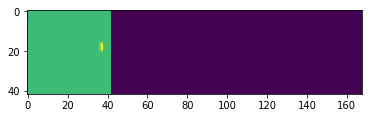

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,s.shape[-1]).T)

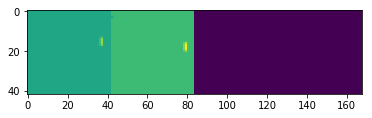

In [7]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T)

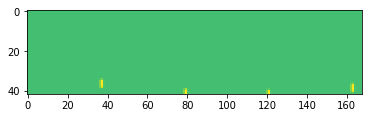

In [8]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T,vmin=0)

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from estool.es import PEPG
from tqdm import tqdm
from pong import make_pong
import numpy as np

def create_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', 
                     data_format='channels_first', input_shape=(4, 42, 42)))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))

    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(env.action_space.n, activation='softmax'))
     
    return model

def get_param_shapes(model):
    param_shapes = []
    for weight in model.get_weights():
        param_shapes.append(np.shape(weight))
    return param_shapes

def set_params(model, param, param_shape_list):
    param_nums = [int(np.prod(shape)) for shape in param_shape_list]
    params = []
    pos = 0
    for ind, num in enumerate(param_nums):
        params.append(np.reshape(param[pos:pos+num], 
                                 param_shape_list[ind]))
        pos += num
    model.set_weights(params)
    return model

def fit_func(model, t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(range(env.action_space.n), 
                             p=model.predict(np.expand_dims(s, 0))[0])
        new_s, r, done, _ = env.step(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return total_reward

def es(solver, param_shape_list):
    history = []
    for j in range(4000):
        solutions = solver.ask()
        fitness_list = [fit_func(set_params(
            model, solutions[i], param_shape_list)) for i in tqdm(range(solver.popsize))]
        solver.tell(fitness_list)
        result = solver.result()
        best_sol, best_fitness = result[0], result[1]
        history.append(best_fitness)
        print("fitness at iteration {}: {}".format((j+1), best_fitness))
    print("fitness score at this local optimum: {}".format(best_fitness))

def main():
    env = make_pong()
    model = create_model()
    param_shape_list = get_param_shapes(model)
    NPARAMS = np.sum([int(np.prod(shape)) for shape in param_shape_list])
    # defines PEPG (NES) solver
    pepg = PEPG(NPARAMS,           # number of model parameters
                sigma_init=0.5,                  # initial standard deviation
                learning_rate=0.1,               # learning rate for standard deviation
                learning_rate_decay=1.0,       # don't anneal the learning rate
                popsize=100,             # population size
                average_baseline=True,          # set baseline to average of batch
                weight_decay=0.00,            # weight decay coefficient
                rank_fitness=True,           # use rank rather than fitness numbers
                forget_best=False)            # don't keep the historical best solution)
    es(pepg, param_shape_list)

In [86]:
main()


  9%|▉         | 9/100 [00:28<04:45,  3.14s/it]

KeyboardInterrupt: 